In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from tqdm import tqdm

from google.colab import files
import pickle

In [33]:

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 26
matplotlib.rcParams.update({'font.size': fontsize})
from matplotlib.pyplot import figure

In [34]:
criterion = nn.CrossEntropyLoss() # supervised classification loss
criterion_nonreduced = nn.CrossEntropyLoss(reduce=False) # supervised classification loss

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [35]:
!nvidia-smi

Mon May 15 14:45:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |   7349MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set-Up

In [36]:
# LENET parameters
RANDOM_SEED = 2147483647
LEARNING_RATE = 0.01 #0.0001 for MLP
SUBSET_SIZE = 50000
TEST_SUBSET_SIZE = 10000
N_ITERS = 30000
BATCH_SIZE = 200
BATCH_SIZE_TEST = 1000


IMG_SIZE = 32
N_CLASSES = 10

#Set to zero to disconnect L2. 
weight_decay = 0.01

setting_name=f"rs_{RANDOM_SEED}_inception_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{BATCH_SIZE}_wd_{weight_decay}" 
setting_name

'rs_2147483647_inception_lr_0.01_trainsize_50000_testsize_10000_niters_30000_batchsize_200_wd_0.01'

In [37]:
use_cifar = True
use_mnist = False

# Data

In [38]:
# setup devices
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(RANDOM_SEED)
else:
    device = torch.device("cpu")

transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                 torchvision.transforms.ToTensor()])

transforms_crop = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop((32, 32),  scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                 torchvision.transforms.ToTensor()])

In [39]:
!nvidia-smi

Mon May 15 14:45:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |   7349MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:

train_dataset = datasets.CIFAR10(root='cifar_data', 
                                train=True, 
                                transform=transforms,
                                download=True)

train_dataset_crop = datasets.CIFAR10(root='cifar_data', 
                                train=True, 
                                transform=transforms_crop,
                                download=True)

test_dataset = datasets.CIFAR10(root='cifar_data', 
                                train=False, 
                                transform=transforms)


Files already downloaded and verified
Files already downloaded and verified


In [41]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

class CIFAR10Corrupted(CIFAR10):
    def __init__(self, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        self.n_classes = num_classes
        self.corrupt_labels()

    def corrupt_labels(self):
        labels = np.array(self.targets)
        np.random.seed(42)
        rnd_labels = np.random.choice(self.n_classes, size = len(self.targets))
        self.targets = rnd_labels.flatten()

def get_cifar_dataloaders_corrupted():

    trainset = CIFAR10Corrupted(root='cifar_data', train=True, download=True, transform=transforms)
    return trainset


In [42]:
train_dataset_shuffled = get_cifar_dataloaders_corrupted()

Files already downloaded and verified


In [43]:
train_dataset = torch.utils.data.Subset(train_dataset, list(range(0, SUBSET_SIZE)))
train_dataset_crop = torch.utils.data.Subset(train_dataset_crop, list(range(0, SUBSET_SIZE)))
train_dataset_shuffled = torch.utils.data.Subset(train_dataset_shuffled, list(range(0, SUBSET_SIZE)))

test_dataset = torch.utils.data.Subset(test_dataset, list(range(0, TEST_SUBSET_SIZE)))

In [44]:

test_loader_batch = torch.utils.data.DataLoader(dataset=test_dataset, 
                          batch_size=BATCH_SIZE_TEST, 
                          shuffle=False)

# Model

In [45]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionNet(nn.Module):
    def __init__(self, num_classes, input_channels):
        super().__init__()
        
        self.conv1 = ConvModule(in_channels =input_channels,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [46]:
from torchvision.models import resnet50

def createmodel():
  return InceptionNet(10, train_dataset[0][0].shape[0])

# Code

In [47]:
def get_log_p(device, model, loader):
    cce = nn.CrossEntropyLoss(reduction = "none") # supervised classification loss
    model.eval()
    aux = []
    with torch.no_grad():
      for data, targets in loader:
          data = data.to(device)
          targets = targets.to(device)
          logits = model(data)
          probs = F.softmax(logits, dim=1)
          log_p = -cce(logits, targets) # supervised loss
          aux.append(log_p)
    return torch.cat(aux)

In [48]:
#Binary Search for lambdas
def rate_function_BS(model, s_value):
  if (s_value<0):
    min_lamb=torch.tensor(-10000).to(device)
    max_lamb=torch.tensor(0).to(device)
  else:
    min_lamb=torch.tensor(0).to(device)
    max_lamb=torch.tensor(10000).to(device)

  s_value=torch.tensor(s_value).to(device)
  log_p = get_log_p(device, model, test_loader_batch)
  return aux_rate_function_TernarySearch(log_p, s_value, min_lamb, max_lamb, 0.001)

def eval_log_p(log_p, lamb, s_value):
  jensen_val=(torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - lamb *torch.mean(log_p))
  return lamb*s_value - jensen_val

def aux_rate_function_BinarySearch(log_p, s_value, low, high, epsilon):
  
  while (high - low) > epsilon:
      mid = (low + high) / 2
      print(mid)
      print(eval_log_p(log_p, low, s_value))
      print(eval_log_p(log_p, mid, s_value))
      print(eval_log_p(log_p, high, s_value))
      print("--")
      if eval_log_p(log_p, mid, s_value) < eval_log_p(log_p, high, s_value):
          low = mid
      else:
          high = mid

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


def aux_rate_function_TernarySearch(log_p, s_value, low, high, epsilon):

  while (high - low) > epsilon:
    mid1 = low + (high - low) / 3
    mid2 = high - (high - low) / 3

    if eval_log_p(log_p, mid1, s_value) < eval_log_p(log_p, mid2, s_value):
        low = mid1
    else:
        high = mid2

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]

import math
def aux_rate_function_golden_section_search(log_p, s_value, a, b, epsilon):
    """
    Maximizes a univariate function using the golden section search algorithm.

    Parameters:
        f (function): The function to minimize.
        a (float): The left endpoint of the initial search interval.
        b (float): The right endpoint of the initial search interval.
        tol (float): The error tolerance value.

    Returns:
        float: The x-value that minimizes the function f.
    """
    # Define the golden ratio
    golden_ratio = (torch.sqrt(torch.tensor(5).to(device)) - 1) / 2

    # Define the initial points
    c = b - golden_ratio * (b - a)
    d = a + golden_ratio * (b - a)

    # Loop until the interval is small enough
    while abs(c - d) > epsilon:
        # Compute the function values at the new points
        fc = eval_log_p(log_p, c, s_value)
        fd = eval_log_p(log_p, d, s_value)

        # Update the interval based on the function values
        if fc > fd:
            b = d
            d = c
            c = b - golden_ratio * (b - a)
        else:
            a = c
            c = d
            d = a + golden_ratio * (b - a)

    # Return the midpoint of the final interval
    mid = (a + b) / 2
    return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


In [49]:
def eval_jensen(model, lambdas):
  log_p = get_log_p(device, model, test_loader_batch)
  return np.array(
      [
          (torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - torch.mean(lamb * log_p)).detach().cpu().numpy() for lamb in lambdas
       ])

def inverse_rate_function(model, lambdas, rate_vals):
  jensen_vals = eval_jensen(model, lambdas)

  return np.array([ np.min((jensen_vals + rate)/lambdas) for rate in rate_vals])


In [50]:
def eval(device, model, loader, criterion):
    correct = 0
    total = 0 
    losses = []
    model.eval()
    with torch.no_grad():
        for data, targets in loader:
            total += targets.size(0)
            data = data.to(device)
            targets = targets.to(device)
            logits = model(data)
            probs = F.softmax(logits, dim=1)
            predicted = torch.argmax(probs, 1)
            correct += (predicted == targets).sum().detach().cpu().numpy()

            loss = criterion(logits, targets) # supervised loss
            losses.append(loss.detach().cpu().numpy())
      
    return correct, total, np.mean(losses), np.var(losses)

In [51]:
SKIP=False
lambdas = np.arange(-10, 10, 0.01)

def train(model, train_loader, weight_decay=0):

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose = False)
    data_iter = iter(train_loader)
    iters_per_epoch = len(data_iter)
    aux_loss = 1
    tq = tqdm(range(N_ITERS))
    for it in tq:

            model.train()

            try:
                inputs, target = next(data_iter)
            except StopIteration:
                # StopIteration is thrown if dataset ends
                # reinitialize data loader
                data_iter = iter(train_loader)
                inputs, target = next(data_iter)
                

            inputs = inputs.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            logits = model(inputs) # forward pass

            loss = criterion(logits, target) # supervised loss
            aux_loss += loss.detach().cpu().numpy()

            tq.set_postfix({'Train cce': loss.detach().cpu().numpy()})


            if weight_decay>0:
              # Add L2 regularization to the loss
              l2_reg = torch.tensor(0.).to(device)
              for param in model.parameters():
                  l2_reg += torch.norm(param)
              loss += weight_decay * l2_reg

            loss.backward() # computes gradients
            optimizer.step()

            if it % iters_per_epoch == 0:
              scheduler.step()
              if aux_loss/iters_per_epoch < 0.005:
                print("Early-stopping")
                break
              aux_loss = 0

            

    return model

# Training

In [52]:
models = [createmodel().to(device) for _ in range(5)]
loader = []

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset_crop, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset_crop, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
loader.append(torch.utils.data.DataLoader(dataset=train_dataset_shuffled, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))


weight_decays = [0.0, weight_decay, 0.0, weight_decay, 0.0]
labels = ["Inception", "L2", "Crop", "L2-Crop", "Random"]


In [53]:
jet = plt.cm.get_cmap('Dark2')
colors = {
    "Inception": jet(0),
    "L2": jet(1),
    "Crop": jet(2),
    "L2-Crop": jet(3),
    "Random": jet(4)
}


markers = {
    "Inception": "X",
    "L2": "s",
    "Crop": "^",
    "L2-Crop": "<",
    "Random": "*"
}
     


In [ ]:
results = []
for i in range(len(models)):
  results.append(train(models[i], loader[i], weight_decay=weight_decays[i]))
  with open(f'sgd_images/{setting_name}_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

 11%|█         | 3250/30000 [06:10<50:48,  8.78it/s, Train cce=0.0034393026]


Early-stopping


 12%|█▎        | 3750/30000 [07:21<51:29,  8.50it/s, Train cce=0.003266327]


Early-stopping


 52%|█████▏    | 15500/30000 [34:04<31:52,  7.58it/s, Train cce=0.020732587]


Early-stopping


 60%|██████    | 18000/30000 [42:15<28:10,  7.10it/s, Train cce=0.0073527694]


Early-stopping


100%|██████████| 30000/30000 [55:44<00:00,  8.97it/s, Train cce=0.017254101]


In [75]:
eval(device, createmodel().to(device), test_loader_batch, criterion)

(1000, 10000, 2.302629, 1.3532276e-07)

In [ ]:
for i in range(len(models)):
  print(labels[i])
  print("Train", eval(device, models[i],  loader[i], criterion))
  print("Test", eval(device, models[i],  test_loader_batch, criterion))

Inception
Train (49999, 50000, 0.0023565707, 4.6568243e-07)
Test (8436, 10000, 0.6557811, 0.0035014781)
Inception-L2
Train (50000, 50000, 0.0022527338, 1.2671833e-07)
Test (8660, 10000, 0.49843162, 0.0018191319)
Inception-Crop
Train (49971, 50000, 0.0042447145, 7.892405e-06)
Test (8689, 10000, 0.5871979, 0.0023411235)
Inception-L2-Crop
Train (49993, 50000, 0.004091027, 3.2923244e-06)
Test (8845, 10000, 0.4202022, 0.0020244843)
Inception-Random
Train (50000, 50000, 0.01237456, 1.2919899e-06)
Test (1013, 10000, 5.5234256, 0.012642367)


In [ ]:
BATCH_LOSS=0
TRAIN_LOSS=1
TEST_LOSS=2
VARIANCE=3
MODELS=4
train_loss = [BATCH_LOSS, BATCH_LOSS, BATCH_LOSS, BATCH_LOSS, BATCH_LOSS] 

# Figure 4: Jensen-Gap Functions Evolution

In [ ]:
with open(f"sgd_images/{setting_name}_results.pickle", "rb") as handle:
  results = pickle.load(handle)

In [ ]:
lambdas = np.arange(0, 0.5, 0.01)
jensens = []

for i in range(len(models)):
  jensens.append(eval_jensen(results[i].to(device), lambdas))


new_model = createmodel().to(device)
jensens.append(eval_jensen(new_model.to(device), lambdas))

In [ ]:

for i in range(len(models)):
  print()
  l2_reg = 0
  for param in results[i].parameters():
    l2_reg += torch.norm(param)
  print(labels[i], ": ", l2_reg.detach().cpu().numpy())

for param in new_model.parameters():
  l2_reg += torch.norm(param)
print("Initial model: ", l2_reg.detach().cpu().numpy())



Inception :  304.169

L2 :  200.12051

Crop :  309.86862

L2-Crop :  130.98254

Random :  311.16617
Initial model:  593.6332


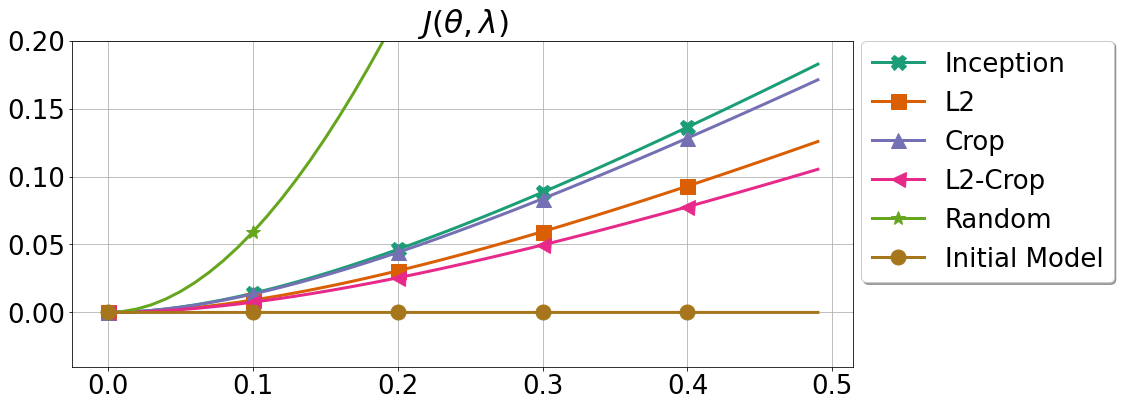

In [ ]:
plt.rcParams['figure.figsize'] = (14, 6)
for i in range(len(jensens)-1):
  plt.plot(lambdas, jensens[i], label=labels[i] ,linewidth=3, color = colors[labels[i]], marker = markers[labels[i]],  markersize=15, markevery=10)


plt.plot(lambdas, jensens[-1], label="Initial Model" ,linewidth=3, color = jet(6), marker = "o",  markersize=15, markevery=10)


plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.04),
          ncol=1, fancybox=True, shadow=True)
#plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
plt.ylim(-0.04,0.2)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")

plt.savefig("sgd_images/jensen_intro.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

In [55]:
s_values = np.arange(0, 0.5, 0.01)
Is = []

for i in range(len(models)):
  Is.append(np.array([rate_function_BS(results[i].to(device), s)[0] for s in s_values]))


new_model = createmodel().to(device)
Is.append(np.array([rate_function_BS(new_model, s)[0] for s in s_values]))

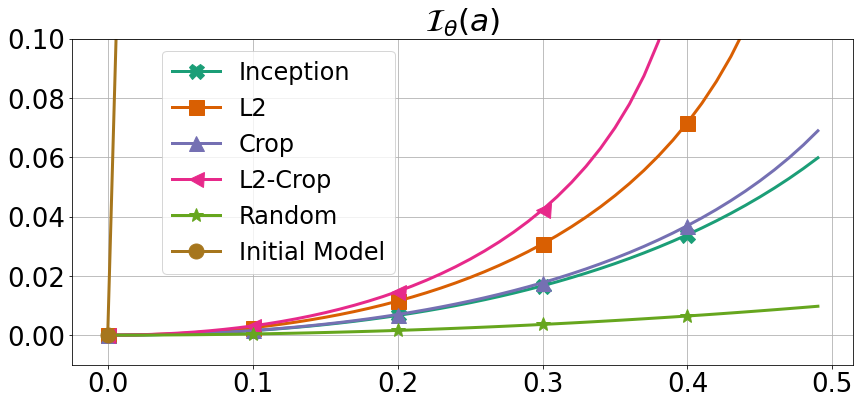

In [74]:
plt.rcParams['figure.figsize'] = (14, 6)
for i in range(len(Is)-1):
  plt.plot(s_values, Is[i], label=labels[i] ,linewidth=3, color = colors[labels[i]], marker = markers[labels[i]],  markersize=15, markevery=10)


plt.plot(s_values, Is[-1], label="Initial Model" ,linewidth=3, color = jet(6), marker = "o",  markersize=15, markevery=10)


#plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.04), ncol=1, fancybox=True, shadow=True)
#plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
plt.legend(fontsize=24, bbox_to_anchor=(0.1, 1))
plt.ylim(-0.01,0.1)
plt.grid()
plt.title(r"${\cal I}_{\theta}(a)$")

plt.savefig("sgd_images/rate_intro.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

# Download Files

In [ ]:
!zip sgd_images/images.zip sgd_images/*.pdf

updating: sgd_images/hist_GD.pdf (deflated 15%)
updating: sgd_images/hist_SGD-L2.pdf (deflated 16%)
updating: sgd_images/hist_SGD.pdf (deflated 16%)
updating: sgd_images/jensen_epochs.pdf (deflated 9%)
updating: sgd_images/jensen.pdf (deflated 15%)
updating: sgd_images/KL.pdf (deflated 10%)
updating: sgd_images/rates.pdf (deflated 13%)
updating: sgd_images/rates_two_axes.pdf (deflated 9%)
updating: sgd_images/sgd_inverse_rate.pdf (deflated 14%)
updating: sgd_images/sgd_train_test.pdf (deflated 13%)
updating: sgd_images/variance.pdf (deflated 14%)
updating: sgd_images/sgd_test.pdf (deflated 12%)
updating: sgd_images/sgd_train.pdf (deflated 13%)
updating: sgd_images/hist_SGD-DA.pdf (deflated 16%)
updating: sgd_images/hist_SGD-L2-DA.pdf (deflated 16%)
updating: sgd_images/jensen_intro.pdf (deflated 13%)


In [ ]:
files.download('sgd_images/images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -l sgd_images

total 2960424
-rw-r--r-- 1 root root      8387 Apr 26 16:50 cifar_inception_SGD-DA_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_rates_rates.pickle
-rw-r--r-- 1 root root 739410204 Apr 26 15:11 cifar_inception_SGD-DA_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_results.pickle
-rw-r--r-- 1 root root      8387 Apr 26 16:56 cifar_inception_SGD-L2-DA_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_rates_rates.pickle
-rw-r--r-- 1 root root 739411330 Apr 26 16:30 cifar_inception_SGD-L2-DA_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_results.pickle
-rw-r--r-- 1 root root      8387 Apr 26 16:44 cifar_inception_SGD-L2_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_rates_rates.pickle
-rw-r--r-- 1 root root 739411252 Apr 26 13:53 cifar_inception_SGD-L2_lr_0.01_trainsize_50000_testsize_10000_niters_10001_batchsize_250_wd_0.01_results.pickle
-rw-r--r-- 1 root ro